# Attempt to use PCA to predict passenger vehicle exports using pollution data from aqicn

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_and_clean(filepath):
    df = pd.read_csv(filepath, skipinitialspace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Convert all columns (except date) to numeric
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by date
    df = df.sort_values(by='date').reset_index(drop=True)

    return df

# Data path
pollution_df = read_and_clean('aqicn_data/shanghai.csv')

pollution_df.head()

,date,pm25,pm10,o3,no2,so2,co
0,2014-01-01,NaN,121.0,29.0,57.0,30.0,14.0
1,2014-01-02,188.0,92.0,39.0,54.0,17.0,13.0
2,2014-01-03,170.0,105.0,21.0,55.0,32.0,12.0
3,2014-01-04,191.0,94.0,18.0,36.0,19.0,9.0
4,2014-01-05,176.0,53.0,13.0,37.0,13.0,7.0


In [3]:
# Load the original vehicle export data
vehicle_df = pd.read_csv("anup_data/China_Passenger_Vhicle.csv", skipinitialspace=True)

# Rename columns for consistency
vehicle_df.rename(columns={
    'Date': 'date',
    'Passenger Vehicle Exports (Units)': 'units'
}, inplace=True)

# Convert 'date' to datetime
vehicle_df['date'] = pd.to_datetime(vehicle_df['date'], errors='coerce')

# Drop rows with invalid dates or missing export values
vehicle_df.dropna(subset=['date', 'units'], inplace=True)

# Set date as index and sort
vehicle_df.set_index('date', inplace=True)
vehicle_df.sort_index(inplace=True)

# Reindex to daily frequency
daily_index = pd.date_range(start=vehicle_df.index.min(), end=vehicle_df.index.max(), freq='D')
vehicle_df = vehicle_df.reindex(daily_index)

# Interpolate missing values linearly
vehicle_df['units'] = vehicle_df['units'].interpolate(method='linear')

# Reset index and rename for clarity
vehicle_df = vehicle_df.reset_index().rename(columns={'index': 'date'})

vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4139 entries, 0 to 4138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4139 non-null   datetime64[ns]
 1   units   4139 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 64.8 KB


In [4]:
# Set date as index for both DataFrames
pollution_df.set_index('date', inplace=True)
vehicle_df.set_index('date', inplace=True)

# Concatenate on common dates (intersection of index)
combined = pd.concat([pollution_df, vehicle_df], axis=1, join='inner')

# Optional: reset index if you want date as a column again
combined.reset_index(inplace=True)

combined.head(20)

,date,pm25,pm10,o3,no2,so2,co,units
0,2014-01-31,230.0,107.0,47.0,12.0,9.0,8.0,45685.000000
1,2014-02-01,201.0,58.0,37.0,20.0,7.0,6.0,45146.071429
2,2014-02-02,140.0,132.0,30.0,21.0,6.0,16.0,44607.142857
3,2014-02-03,236.0,59.0,31.0,9.0,5.0,5.0,44068.214286
4,2014-02-04,124.0,38.0,34.0,5.0,7.0,3.0,43529.285714
5,2014-02-05,75.0,21.0,30.0,9.0,6.0,5.0,42990.357143
6,2014-02-06,64.0,10.0,26.0,11.0,4.0,4.0,42451.428571
7,2014-02-07,55.0,16.0,28.0,12.0,6.0,5.0,41912.500000
8,2014-02-08,61.0,41.0,29.0,12.0,8.0,6.0,41373.571429
9,2014-02-09,121.0,49.0,30.0,11.0,8.0,5.0,40834.642857


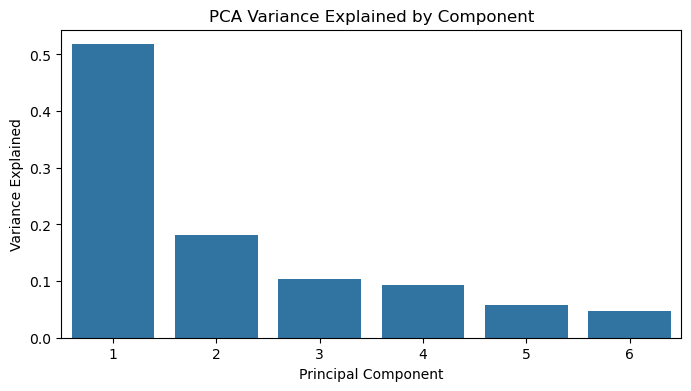

R^2 score of PCA model predicting "units": 0.0926


In [5]:
# Step 1: Drop NaNs
clean_df = combined.dropna()

# Step 2: Select features and standardize
pollutants = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
X = clean_df[pollutants]
y = clean_df['units']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 4: Regress 'units' on PCA components
reg = LinearRegression()
reg.fit(X_pca, y)

# Step 5: Plot explained variance
plt.figure(figsize=(8, 4))
sns.barplot(x=np.arange(1, len(pollutants)+1), y=pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Variance Explained by Component')
plt.show()

# Optional: R^2 score
print(f'R^2 score of PCA model predicting "units": {reg.score(X_pca, y):.4f}')

Terrible